<a href="https://colab.research.google.com/github/Boughdiri-Ahmed/project_euler/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math as m

def get_data(path):
    """Gets the data and puts it into numpy arrays

    Args:
        path: string
        path of the data directory from the main directory
    """
    X = np.char.strip(np.genfromtxt(path, dtype=str), '"').astype(float)[:, :2]
    Y = np.char.strip(np.genfromtxt(path, dtype=str), '"').astype(
        float)[:, 2:].astype(int).reshape(len(X), 1)
    return X, Y


X_a, Y_a = get_data("trainA")
X_b, Y_b = get_data("trainB")
X_c, Y_c = get_data("trainC")

X_a_test, Y_a_test = get_data("testA")
X_b_test, Y_b_test = get_data("testB")
X_c_test, Y_c_test = get_data("testC")

def sigmoid(x):
    return 1/(1+m.exp(-x))

In [ ]:
def MLE_GDA(X, Y, X_test = None, Y_test = None, plot=False):
    """Compute the MLE of the Gaussian discriminant analysis,
    predicts a test set a compute both misclassification error
    plots the results.

    Args:
        X: numpy array
        training set input
        Y: numpy array
        training set output
        X_test: numpy array
        test set input
        Y_test: numpy array
        test set output
        plot: bool
    """

    def get_MLE_params(X, Y):
        """Compute the MLE parameters of the Gaussian discriminant analysis,
        

        Args:
            X: numpy array
            training set input
            Y: numpy array
            training set output

        Return:
            Pi: float
            estimator pi value
            mu_0: numpy array
            estimator mu_0 value
            mu_1: numpy array
            estimator mu_1 value
            Sigma: numpy array
            estimator Sigma value
        """
        Pi = sum(Y)/len(Y)
        mu_1 = sum(X*Y)/sum(Y)
        mu_0 = sum(X*(1-Y))/sum(1-Y)
        Sigma = sum([Y[i]*np.dot((X[i]-mu_1)[:, None], (X[i]-mu_1)[:, None].T) + (1-Y[i])
                    * np.dot((X[i]-mu_0)[:, None], (X[i]-mu_0)[:, None].T) for i in range(len(Y))])/len(Y)
        return Pi, mu_1, mu_0, Sigma

    def theta(Pi, mu_1, mu_0, Sigma):
        """Compute the MLE parameters of the Gaussian discriminant analysis,
        

        Args:
            Pi: float
            estimator pi value
            mu_0: numpy array
            estimator mu_0 value
            mu_1: numpy array
            estimator mu_1 value
            Sigma: numpy array
            estimator Sigma value

        Return:
            theta: numpy array
            value of theta parameter
            theta_0: numpy array
            value of theta_0 parameter
        """
        return (np.dot(np.linalg.inv(Sigma), mu_1-mu_0), np.dot(mu_0, np.dot(np.linalg.inv(Sigma), mu_0))/2 - np.dot(mu_1, np.dot(np.linalg.inv(Sigma), mu_1))/2+np.log(Pi/(1-Pi)))

    Pi, mu_1, mu_0, Sigma = get_MLE_params(X,Y)
    theta_, theta_0 = theta(Pi, mu_1, mu_0, Sigma)

    Y_predict_train = np.zeros(len(Y))
    for i, x in enumerate(X):
        if sigmoid(np.dot(theta_, x) + theta_0) > 0.5:
            Y_predict_train[i] = 1
    missclass_error_train = np.count_nonzero(Y.reshape(len(Y)) == Y_predict_train)/len(Y)
    
    if X_test is not None:
        Y_predict = np.zeros(len(Y_test))
        for i, x in enumerate(X_test):
            if sigmoid(np.dot(theta_, x) + theta_0) > 0.5:
                Y_predict[i] = 1
    missclass_error_test = np.count_nonzero(Y_test.reshape(len(Y_test)) == Y_predict)/len(Y_test)
    
    if plot:
        colormap = np.array(['r', 'b'])
        T = np.linspace(min(X[:,0])-1, max(X[:,1])+1, 200)
        F = -(theta_0+theta_[0]*T)/theta_[1]
        fig, axs = plt.subplots(1, 2)
        axs[0].plot(T,F)
        axs[0].set_title('Training missclass error: ' + str(100*round(1-missclass_error_train, 5))+'%')
        axs[0].scatter(X[:,0], X[:,1], c = colormap[Y.reshape(len(Y))])
        if X_test is not None:
            axs[1].plot(T,F)
            axs[1].set_title('Test missclass error: ' + str(100*round(1-missclass_error_test, 5))+'%')
            axs[1].scatter(X_test[:,0], X_test[:,1], c = colormap[Y_test.reshape(len(Y_test))])
        plt.show()

    return None

In [ ]:
def logistic_regression(X, Y, X_test=None, Y_test=None, lamb=0.2, tol=1e-5, num_iterations=1000, plot=False):
    """Compute a logistic regression,
    predicts a test set a compute both misclassification error,
    plots the results.

    Args:
        X: numpy array
        training set input
        Y: numpy array
        training set output
        X_test: numpy array
        test set input
        Y_test: numpy array
        test set output
        lamb: float
        Ridge parameter
        tol: float
        tolerance of the Newton-Raphson parameter
        num_iteration: int
        number of max iterations of Newton-Raphson
        plot: bool
    """
    w = np.ones((len(X[0])))
    new_w = np.zeros((len(X[0])))
    b = 1
    new_b = 0
    n_iter = 0
    State = True
    while (n_iter < num_iterations and State):
        n_iter += 1
        w = np.copy(new_w)
        b = new_b
        # we compute the matrices Phi and R
        Phi = np.array([sigmoid(np.dot(w, X[i])+b) for i in range(len(Y))])
        R = np.diag([(sigmoid(np.dot(w, X[i]) + b)-1) *
                    sigmoid(np.dot(w, X[i]) + b) for i in range(len(Y))])
        # we update the parameters according to the Newton-Raphson formula
        new_w = w - np.dot(np.linalg.inv(np.dot(X.T, np.dot(R, X)) - lamb*np.eye(len(X[0]))), np.dot(X.T, Y-Phi.reshape(len(Y), 1)
                                                                                                     ) - lamb*w.reshape((len(X[0]), 1))).reshape(len(X[0]))
        new_b = b - (np.sum(Y.reshape(len(Y))-Phi)-lamb*b)/(np.sum(R)-lamb)
        State = not np.array_equal(new_w, w) or np.not_equal(new_b, b)

    Y_predict_train = np.zeros(len(Y))
    for i, x in enumerate(X):
        if sigmoid(np.dot(w, x) + b) > 0.5:
            Y_predict_train[i] = 1
    missclass_error_train = np.count_nonzero(
        Y.reshape(len(Y)) == Y_predict_train)/len(Y)

    if X_test is not None:
        Y_predict = np.ones(len(Y_test))
        for i, x in enumerate(X_test):
            if sigmoid(np.dot(w, x) + b) < 0.5:
                Y_predict[i] = 0
    missclass_error_test = np.count_nonzero(
        Y_test.reshape(len(Y_test)) == Y_predict)/len(Y_test)

    if plot:
        colormap = np.array(['r', 'b'])
        T = np.linspace(min(X[:, 0])-1, max(X[:, 1])+1, 200)
        F = -(b+w[0]*T)/w[1]
        fig, axs = plt.subplots(1, 2)
        axs[0].plot(T, F)
        axs[0].set_title('Training missclass error: ' +
                         str(100*round(1-missclass_error_train, 5))+'%')
        axs[0].scatter(X[:, 0], X[:, 1], c=colormap[Y.reshape(len(Y))])
        if X_test is not None:
            axs[1].plot(T, F)
            axs[1].set_title('Test missclass error: ' +
                             str(100*round(1-missclass_error_test, 2))+'%')
            axs[1].scatter(X_test[:, 0], X_test[:, 1],
                           c=colormap[Y_test.reshape(len(Y_test))])
        plt.show()

    return None


In [ ]:
def linear_regression(X, Y,  X_test = None, Y_test = None, plot=False):
    """Compute a linear regression,
    predicts a test set a compute both misclassification error,
    plots the results.

    Args:
        X: numpy array
        training set input
        Y: numpy array
        training set output
        X_test: numpy array
        test set input
        Y_test: numpy array
        test set output
        plot: bool
    """

    w = np.dot(np.linalg.inv(np.dot(X.T,X - np.mean(X, axis=0))),np.dot(X.T, (Y-np.mean(Y))))
    b = np.mean(Y) - np.dot(w.T, np.mean(X, axis=0))

    Y_predict_train = np.zeros(len(Y))
    for i, x in enumerate(X):
        if np.dot(w.T, x) + b > 0.5:
            Y_predict_train[i] = 1
    missclass_error_train = np.count_nonzero(Y.reshape(len(Y)) == Y_predict_train)/len(Y)

    if X_test is not None:
        Y_predict = np.zeros(len(Y_test))
        for i, x in enumerate(X_test):
            if np.dot(w.T, x) + b > 0.5:
                Y_predict[i] = 1
    missclass_error_test = np.count_nonzero(Y_test.reshape(len(Y_test)) == Y_predict)/len(Y_test)

    if plot:
        colormap = np.array(['r', 'b'])
        T = np.linspace(min(X[:, 0])-1, max(X[:, 1])+1, 200)
        F = -(b - 0.5 +w[0]*T)/w[1]
        fig, axs = plt.subplots(1, 2)
        axs[0].plot(T,F)
        axs[0].set_title('Training missclass error: ' + str(100*round(1-missclass_error_train, 5))+'%')
        axs[0].scatter(X[:,0], X[:,1], c = colormap[Y.reshape(len(Y))])
        if X_test is not None:
            axs[1].plot(T,F)
            axs[1].set_title('Test missclass error: ' + str(100*round(1-missclass_error_test, 5))+'%')
            axs[1].scatter(X_test[:,0], X_test[:,1], c = colormap[Y_test.reshape(len(Y_test))])
        plt.show()

    return None

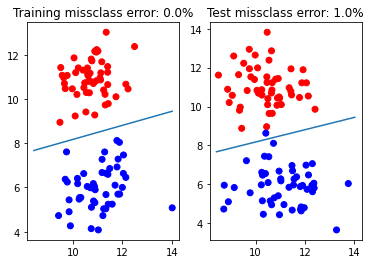

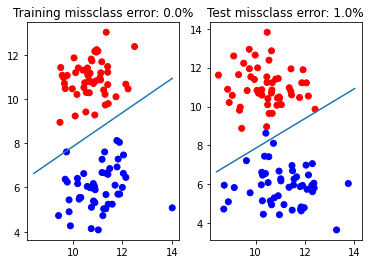

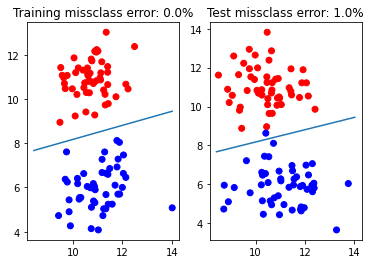

In [ ]:
MLE_GDA(X_a,Y_a,X_a_test, Y_a_test, plot=True)
logistic_regression(X_a, Y_a, X_a_test, Y_a_test, plot= True)
linear_regression(X_a, Y_a, X_a_test, Y_a_test, plot= True)

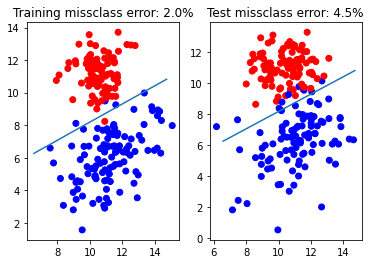

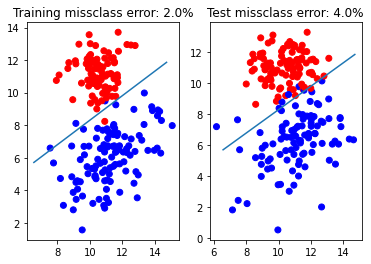

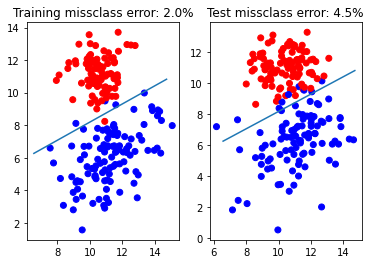

In [ ]:
MLE_GDA(X_b,Y_b,X_b_test, Y_b_test, plot=True)
logistic_regression(X_b, Y_b, X_b_test, Y_b_test, plot= True)
linear_regression(X_b, Y_b, X_b_test, Y_b_test, plot= True)

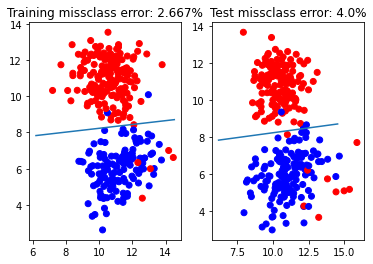

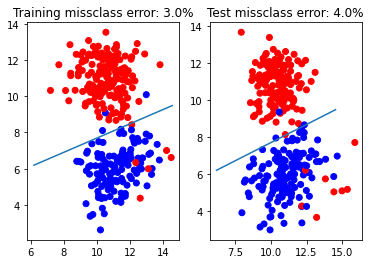

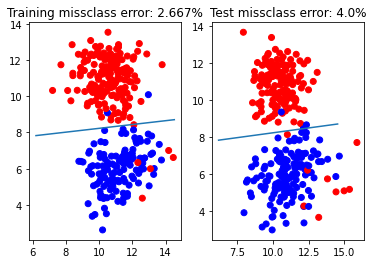

In [ ]:
MLE_GDA(X_c,Y_c,X_c_test, Y_c_test, plot=True)
logistic_regression(X_c, Y_c, X_c_test, Y_c_test, plot= True)
linear_regression(X_c, Y_c, X_c_test, Y_c_test, plot= True)


In [ ]:
!pip install pyreadr

     |████████████████████████████████| 409 kB 22.6 MB/s 


In [ ]:
import pyreadr
import numpy as np
result = pyreadr.read_r('decathlon.RData')
X = result['X'].to_numpy()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3).fit(X)
_, count = np.unique(kmeans.labels_, return_counts=True)


In [ ]:
def EM_algorithm(X, K, num_iterations = 100):

    def normal(x, mu, Sigma):
        return m.exp(-np.dot(x-mu, np.dot(np.linalg.inv(Sigma), (x-mu).T))/2)/((2*m.pi)**(len(x)/2)*m.sqrt(abs(np.linalg.det(Sigma))))
    def gamma(x, k, mus, Sigmas, pis):
        return pis[k]*normal(x, mus[k], Sigmas[k])/sum([pis[j]*normal(x, mus[j], Sigmas[j]) for j in range(K)])
    def get_log_likelihood():
        return sum([m.log(sum([pis[k]*normal(x, mus[k], Sigmas[k]) for k in range(K)]))for x in X])
    
    #initialization

    


    normalize = (np.mean(X))**2
    a = np.random.rand(K)
    pis = a/np.linalg.norm(a)
    mus = np.random.rand(K, len(X[0]))
    Sigmas = np.array([normalize*np.eye(len(X[0])) for k in range(K)])

    a = np.random.rand(K)
    new_pis = a/sum(a)
    new_mus = np.array([np.average(X, axis=0) for k in range(K)])
    new_Sigmas = np.array([normalize*np.eye(len(X[0])) for k in range(K)])

    gammas = np.zeros((len(X),K))
    i=0
    while(not (np.array_equal(pis, new_pis) and np.array_equal(mus, new_mus) and np.array_equal(Sigmas, new_Sigmas)) and i<num_iterations):
        i+=1
        pis = np.copy(new_pis)
        mus = np.copy(new_mus)
        Sigmas = np.copy(new_Sigmas)
        # E-step
        for n in range(len(X)):
            for k in range(K):
                gammas[n,k] = gamma(X[n], k, mus, Sigmas, pis)
        # M-step
        for k in range(K): 
            N_k = sum(gammas[:,k])
            new_pis[k] = N_k/len(X)
            new_mus[k] = np.average(X, axis=0, weights=gammas[:,k])
            new_Sigmas[k] = np.average(np.einsum('ij,ik->ijk', X-mus[k], X-mus[k]), axis=0, weights=gammas[:,k]) + np.eye(len(X[0])) * 1e-4
    return pis, mus, Sigmas, get_log_likelihood()

In [ ]:
#initialize random seed to get the best results
log_lists = [] 
for n in range(200):
    log_lists.append(EM_algorithm(X, 3))
log_lists.sort(key=lambda x:x[-1])

In [ ]:
import pandas as pd
log_lists[-1][1]
pd.DataFrame(log_lists[-1][1], columns = result['X'].columns.values)

,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m
0,10.981667,7.284000,14.442333,1.971667,49.507667,14.577000,43.852000,4.785333,59.494333,277.322333
1,11.186667,7.041667,14.751667,1.943333,50.648333,14.951667,46.276667,4.823333,54.928333,285.838333
2,10.870000,7.378000,14.356000,2.048000,49.030000,14.364000,44.826000,4.552000,55.316000,281.064000


In [ ]:
alpha = 0.1

# 2 clusters
mu1 = [-1, -8]
sig1 = [ [1, 0], [0, 1] ]

mu2 = [5, 15]
sig2 = [ [6, 0], [0, 11] ]

# generate samples
X1 = np.random.multivariate_normal(mu1, sig1, int(100*alpha))
X2 = np.random.multivariate_normal(mu2, sig2, int(100*(1-alpha)))
X3 = np.concatenate((X1,X2),axis=0)

EM_algorithm(X3, 2)

(array([0.1, 0.9]), array([[-1.1144749 , -8.07560759],
        [ 4.83795116, 15.60871976]]), array([[[ 0.74451243, -0.33289807],
         [-0.33289807,  0.99892432]],
 
        [[ 5.71796807, -1.30195559],
         [-1.30195559, 11.65851924]]]), -501.8313681782109)

In [31]:
!git clone https://github.com/jupyter/nbconvert.git
!cd nbconvert

Cloning into 'nbconvert'...
remote: Enumerating objects: 20142, done.
remote: Counting objects: 100% (582/582), done.
remote: Compressing objects: 100% (391/391), done.
remote: Total 20142 (delta 322), reused 284 (delta 136), pack-reused 19560
Receiving objects: 100% (20142/20142), 4.35 MiB | 19.12 MiB/s, done.
Resolving deltas: 100% (13683/13683), done.


decathlon.RData  nbconvert    testA  testC   trainB
drive		 sample_data  testB  trainA  trainC
